# Inversion of Airborne Electromagnetic for Basement Conductors (Caber Dataset)

<!-- Please leave the cell below as it is -->

[![Open In Colab](https://img.shields.io/badge/open%20in-Colab-b5e2fa?logo=googlecolab&style=flat-square&color=ffd670)](https://colab.research.google.com/github/inlab-geo/cofi-examples/blob/main/examples/airborne_em/airborne_em_caber_dataset.ipynb)

<!-- Again, please don't touch the markdown cell above. We'll generate badge 
     automatically from the above cell. -->

<!-- This cell describes things related to environment setup, so please add more text 
     if something special (not listed below) is needed to run this notebook -->

> If you are running this notebook locally, make sure you've followed [steps here](https://github.com/inlab-geo/cofi-examples#run-the-examples-with-cofi-locally)
to set up the environment. (This [environment.yml](https://github.com/inlab-geo/cofi-examples/blob/main/envs/environment.yml) file
specifies a list of packages required to run the notebooks)

In [1]:
# -------------------------------------------------------- #
#                                                          #
#     Uncomment below to set up environment on "colab"     #
#                                                          #
# -------------------------------------------------------- #

# !pip install -U cofi
!pip install git+https://github.com/JuergHauser/PyP223.git

  Cloning https://github.com/JuergHauser/PyP223.git to /tmp/pip-req-build-grf1f6ms
  Running command git clone --filter=blob:none --quiet https://github.com/JuergHauser/PyP223.git /tmp/pip-req-build-grf1f6ms
  Resolved https://github.com/JuergHauser/PyP223.git to commit 62f75ddbfe34de9f10815fe53b09ad8cba299862
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for pyp223: filename=pyp223-0.1.0-cp312-cp312-linux_x86_64.whl size=556187 sha256=4f72e56ea2b129edec7402796c0973b9f163cf14a31ebafb8aea0b43073c80c4
  Stored in directory: /tmp/pip-ephem-wheel-cache-m4op9soz/wheels/c7/ca/d1/986092523f9decc492a4fb6965c41da57dd6f20e24bac3452d
Successfully built pyp223


In [2]:
# !git clone https://github.com/inlab-geo/cofi-examples.git
# %cd cofi-examples/examples/airborne_em

In [19]:
import numpy
import pandas
import matplotlib.pyplot as plt
import cofi

from forward_lib import (
    ForwardWrapper, 
    plot_field_data, 
    plot_field_vertical_vs_tx, 
    get_subset_data_from_gateidx_n_lineid, 
    plot_plate_faces, 
    plot_plate_faces_single
)

numpy.random.seed(42)

## Field dataset preparation

**Read data from files**

In [3]:
waveform = pandas.read_csv("../../data/airborne_em_caber/Caber_Waveform_Final.csv")

print(waveform.shape)
waveform.head()

(3201, 2)


,Time,TX_Current
0,0.000000,0.351242
1,0.005208,0.584812
2,0.010417,0.916027
3,0.015625,1.356280
4,0.020833,1.908350


In [4]:
survey = pandas.read_csv("../../data/airborne_em_caber/Caber_26-10-2012_Final.csv")
caber = survey.loc[(survey['x'] >= 709100) & (survey['y'] <= 5515000)]

print(caber.shape)
caber.head()

(5726, 210)


,BFx[0],BFx[1],BFx[2],BFx[3],BFx[4],BFx[5],BFx[6],BFx[7],BFx[8],BFx[9],...,SFz[43],SFz[44],SFz[45],SFz[46],SFz[47],SFz[48],SFz[49],x,y,z
11555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.028266e-05,0.000154,0.000121,-0.000034,0.000019,NaN,NaN,709369.992210,5.512354e+06,391.774920
11556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.890258e-05,0.000155,0.000129,-0.000039,0.000025,NaN,NaN,709372.239799,5.512356e+06,391.933380
11557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.561633e-06,0.000156,0.000137,-0.000042,0.000033,NaN,NaN,709374.484443,5.512359e+06,392.089797
11558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.981635e-07,0.000158,0.000145,-0.000043,0.000042,NaN,NaN,709376.726018,5.512361e+06,392.244661
11559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.034243e-06,0.000161,0.000152,-0.000043,0.000052,NaN,NaN,709378.964488,5.512364e+06,392.398422


In [5]:
# read time windows from readme file
index = []
middle = []
start = []
end = []
width = []
readme = open("../../data/airborne_em_caber/CaberNorth_readme.txt", "r")

for lino, line in enumerate(readme.readlines()):
    if lino >= 110 and lino <= 143:
        index.append(int(line.split()[0]))
        middle.append(float(line.split()[1]))
        start.append(float(line.split()[2]))
        end.append(float(line.split()[3]))
        width.append(float(line.split()[4]))

windows = pandas.DataFrame(data={'Index':index,'Middle':middle,'Start':start,'End':end,'Width':width})

print(windows.shape)
windows.head()

(34, 5)


,Index,Middle,Start,End,Width
0,14,96.0,90.0,103.0,13.0
1,15,110.0,103.0,118.0,15.0
2,16,126.0,118.0,136.0,18.0
3,17,145.0,136.0,156.0,20.0
4,18,167.0,156.0,179.0,23.0


We organise the data observations into a 1D array that looks like:

```
[transmitter_0_gate_0, transmitter_0_gate_1, ..., transmitter_0_gate_m, 
 transmitter_1_gate_0, transmitter_1_gate_1, ..., transmitter_1_gate_m, 
 ...
 transmitter_n_gate_0, transmitter_n_gate_1, ..., transmitter_n_gate_m]
```

In [6]:
data_x = windows["Middle"].to_numpy() * 1e-6
data_obs = []

for i in range(0, caber.shape[0]):     # for each transmitter
    for j in range(14, 48):         # for each mid time of gate
        data_obs.append(caber.iloc[i][f"SFz[{j}]"])

data_obs = numpy.array(data_obs)

**Problem and system specification**

In [7]:
swx = waveform["Time"].to_numpy() * 1e-6

topn = windows["Start"].to_numpy() * 1e-6
tcls = windows["End"].to_numpy() * 1e-6

survey_data = {
    "nsx": len(swx), 
    "nchnl": len(topn), 
    "swx": swx, 
    "waveform": waveform["TX_Current"].to_numpy(), 
    "topn": topn, 
    "tcls": tcls
}

In [8]:
system_spec = {
    "ncmp": 2, 
    "cmp": 2, 
    "ntrn": 4, 
    "txarea": 3848./4., 
    "ampt": 0
}

In [9]:
problem_setup = {
    "nlyr": 2,                                  # number of layers (icl. halfspace)
    "nstat": 1,                                 # numebr of fiducials/stations
    "nplt": 1,                                  # number of thin plates
    "cellw": 25,                                # cell width
    "pthk": numpy.array([1]),                   # plates thickness
    "plng": numpy.deg2rad(numpy.array([0])),    # plates plunge (orientation)
}

In [10]:
caber

,BFx[0],BFx[1],BFx[2],BFx[3],BFx[4],BFx[5],BFx[6],BFx[7],BFx[8],BFx[9],...,SFz[43],SFz[44],SFz[45],SFz[46],SFz[47],SFz[48],SFz[49],x,y,z
11555,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.028266e-05,0.000154,0.000121,-0.000034,0.000019,NaN,NaN,709369.992210,5.512354e+06,391.774920
11556,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,1.890258e-05,0.000155,0.000129,-0.000039,0.000025,NaN,NaN,709372.239799,5.512356e+06,391.933380
11557,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,8.561633e-06,0.000156,0.000137,-0.000042,0.000033,NaN,NaN,709374.484443,5.512359e+06,392.089797
11558,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-4.981635e-07,0.000158,0.000145,-0.000043,0.000042,NaN,NaN,709376.726018,5.512361e+06,392.244661
11559,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,-8.034243e-06,0.000161,0.000152,-0.000043,0.000052,NaN,NaN,709378.964488,5.512364e+06,392.398422
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17276,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.597518e-05,0.000073,0.000010,-0.000005,0.000068,NaN,NaN,711230.773815,5.514787e+06,384.054957
17277,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.724230e-05,0.000067,0.000016,-0.000010,0.000067,NaN,NaN,711232.963796,5.514789e+06,384.248274
17278,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.783884e-05,0.000061,0.000021,-0.000014,0.000067,NaN,NaN,711235.163219,5.514792e+06,384.440110
17279,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,3.750674e-05,0.000055,0.000025,-0.000018,0.000067,NaN,NaN,711237.375367,5.514795e+06,384.630085


In [11]:
# sort out transmitter locations and ids
n_transmitters = caber.shape[0]
fiducial_id = numpy.arange(n_transmitters)
tx = caber.x.to_numpy()
ty = caber.y.to_numpy()
tz = caber.z.to_numpy()

# assign line id to each line of transmitter
caber_diff = caber["x"].diff().abs() + caber["y"].diff().abs()
line_breakpoints = caber_diff[caber_diff>10].index
caber = caber.assign(line_id=0)
line_id = 0
for idx in reversed(line_breakpoints):
    caber.loc[caber.index > idx, "line_id"] += 1

transmitters_setup = {
    "tx": tx,                                                   # transmitter easting/x-position
    "ty": ty,                                                   # transmitter northing/y-position
    "tz": tz,                                                   # transmitter height/z-position
    "tazi": numpy.deg2rad(numpy.array([90]*n_transmitters)),    # transmitter azimuth
    "tincl": numpy.deg2rad(numpy.array([6]*n_transmitters)),    # transmitter inclination
    "rx": tx,                                                   # receiver easting/x-position
    "ry": ty,                                                   # receiver northing/y-position
    "rz": tz,                                                   # receiver height/z-position
    "trdx": numpy.array([0]*n_transmitters),                    # transmitter receiver separation inline
    "trdy": numpy.array([0]*n_transmitters),                    # transmitter receiver separation crossline
    "trdz": numpy.array([0]*n_transmitters),                    # transmitter receiver separation vertical
    "fiducial_id": fiducial_id,                                 # unique id for each transmitter
    "transmitter_line_id": caber["line_id"].to_numpy()          # id of line for each transmitter
}

In [12]:
example_model_params = {
    "res": numpy.array([1000., 1000.]),        
    "thk": numpy.array([5.]), 
    "peast": numpy.array([175]), 
    "pnorth": numpy.array([100]), 
    "ptop": numpy.array([30]), 
    "pres": numpy.array([0.1]), 
    "plngth1": numpy.array([100]), 
    "plngth2": numpy.array([100]), 
    "pwdth1": numpy.array([0.1]), 
    "pwdth2": numpy.array([90]), 
    "pdzm": numpy.array([75]),
    "pdip": numpy.array([60])
}

**Data visualisation**

We plot the data observations using a subset of data.

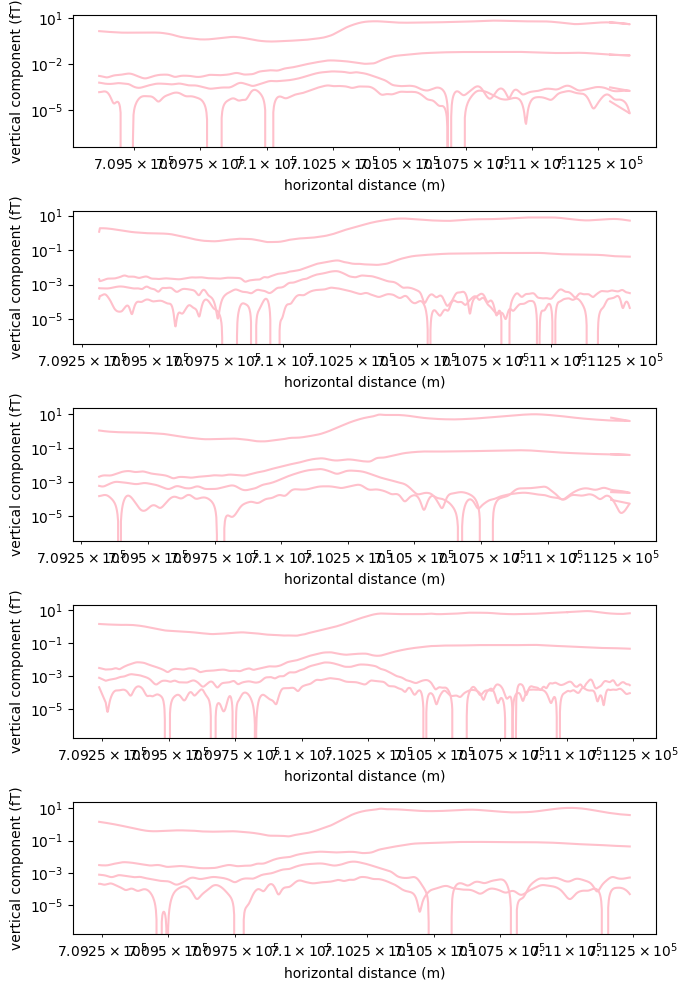

In [13]:
_, axes = plt.subplots(5, 1, figsize=(7, 10))

for i in range(5):
    plot_field_vertical_vs_tx(transmitters_setup, data_obs, label="observed data", gate_idx=numpy.arange(0, 34, 10), 
                              transmitter_line_id=[i], ax=axes[i], color="pink")
plt.tight_layout()

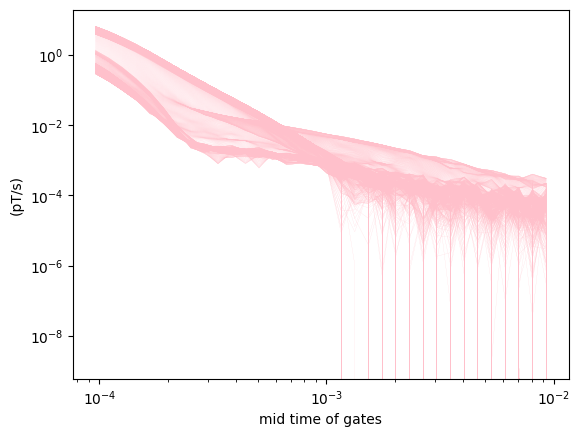

In [14]:
data_gates_middle = windows["Middle"].to_numpy() * 1e-6
_, _, data_obs_to_plot = get_subset_data_from_gateidx_n_lineid(
    transmitters_setup, survey_data, data_obs, gate_idx=None, transmitter_line_id=[0]
)
_, ax = plt.subplots()
plot_field_data(data_gates_middle, data_obs_to_plot, label="subset of data observations", ax=ax, color="pink", linewidth=0.1)

**Get a subset of data for inversion**

In [15]:
transmitters_setup, survey_data, data_obs = get_subset_data_from_gateidx_n_lineid(
    transmitters_setup, survey_data, data_obs, gate_idx=None, transmitter_line_id=[1]
)

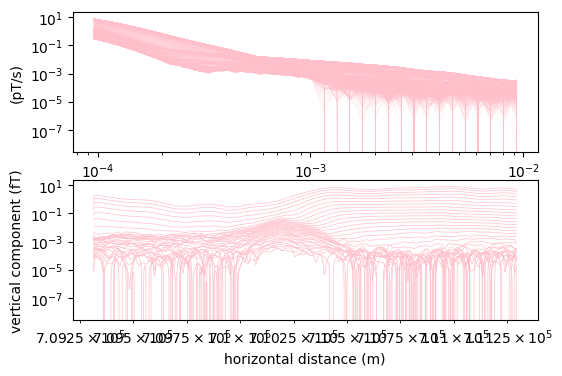

In [16]:
_, axes = plt.subplots(2, 1, figsize=(6, 4))
plot_field_vertical_vs_tx(transmitters_setup, data_obs, label="observed data", ax=axes[1], color="pink", linewidth=0.5)
plot_field_data(data_gates_middle, data_obs, label="observed data", ax=axes[0], color="pink", linewidth=0.1)

## Forward utility definition

In [17]:
forward = ForwardWrapper(example_model_params, problem_setup, system_spec, transmitters_setup, survey_data, 
                         ["pdip", "peast", "ptop", "pwdth2"], data_returned=["vertical"])

In [18]:
# check the order of parameters in a model vector
forward.params_to_invert

['pdip', 'peast', 'ptop', 'pwdth2']

## Run the inversion

**Initialise a model for inversion**

In [1]:
init_param_value = numpy.array([45, 150, 20, 80])

NameError: name 'numpy' is not defined

In [ ]:
data_pred_init_model = forward(init_param_value)

_, axes = plt.subplots(2, 1, figsize=(6, 4))
plot_field_data(data_gates_middle, data_obs, label="observed data", 
                ax=axes[0], color="pink", linewidth=0.1)
plot_field_data(data_gates_middle, data_pred_init_model, label="initial model", 
                ax=axes[0], color="lightblue", linestyle=".", linewidth=0.1)
plot_field_vertical_vs_tx(transmitters_setup, data_obs, label="observed data", 
                          ax=axes[1], color="pink", linewidth=0.5)
plot_field_vertical_vs_tx(transmitters_setup, data_pred_init_model, label="initial model",
                          ax=axes[1], color="lightblue", linewidth=0.5)

**Define helper functions for inversion**

In [ ]:
def my_objective(model):
    dpred = forward(model)
    residual = dpred - data_obs
    return residual.T @ residual

def my_gradient(model):
    dpred = forward(model)
    jacobian = forward.jacobian(model)
    residual = dpred - data_obs
    return 2 * jacobian.T @ residual

def my_hessian(model):
    jacobian = forward.jacobian(model)
    return 2 * jacobian.T @ jacobian

**Define CoFI problem**

In [ ]:
my_problem = cofi.BaseProblem()
my_problem.set_objective(my_objective)
my_problem.set_gradient(my_gradient)
my_problem.set_hessian(my_hessian)
my_problem.set_initial_model(init_param_value)

**Define CoFI options**

In [ ]:
my_options = cofi.InversionOptions()
my_options.set_tool("scipy.optimize.minimize")
my_options.set_params(method="Newton-CG")

**Define CoFI inversion**

In [ ]:
my_inversion = cofi.Inversion(my_problem, my_options)
my_result = my_inversion.run()
print(my_result.model)

## Plotting

**Plotting the data**

In [ ]:
data_pred_init_model = forward(init_param_value)

_, axes = plt.subplots(2, 1, figsize=(6, 4))
plot_field_data(data_gates_middle, data_obs, label="observed data", 
                ax=axes[0], color="pink", linewidth=0.1)
plot_field_data(data_gates_middle, data_pred_init_model, label="initial model", 
                ax=axes[0], color="lightblue", linestyle=".", linewidth=0.1)
plot_field_vertical_vs_tx(transmitters_setup, data_obs, label="observed data", 
                          ax=axes[1], color="pink", linewidth=0.5)
plot_field_vertical_vs_tx(transmitters_setup, data_pred_init_model, label="initial model",
                          ax=axes[1], color="lightblue", linewidth=0.5)

: 

**Plotting the model**

In [ ]:
# _, axes = plt.subplots(2, 2, sharex="col")
# axes[1,1].axis("off")
# plot_plate_faces(
#     "plate_true", forward, true_param_value, 
#     axes[0,0], axes[0,1], axes[1,0], color="purple", label="true model"
# )
# plot_plate_faces(
#     "plate_init", forward, init_param_value, 
#     axes[0,0], axes[0,1], axes[1,0], color="green", label="init model"
# )
# plot_plate_faces(
#     "plate_inverted", forward, my_result.model, 
#     axes[0,0], axes[0,1], axes[1,0], color="red", label="inverted model", linestyle="dotted"
# )
# axes[0,0].legend()
# axes[0,1].legend()
# axes[1,0].legend()
# plt.tight_layout()

In [ ]:
# _, ax = plt.subplots(1, 1)
# plot_plate_faces_single("plate_true", "xz", forward, true_param_value, ax, color="purple", label="true model")
# plot_plate_faces_single("plate_init", "xz", forward, init_param_value, ax, color="green", label="init model")
# plot_plate_faces_single("plate_inverted", "xz", forward, my_result.model, ax, color="red", label="inverted model", linestyle="dotted")
# ax.legend();

---
## Watermark

<!-- Feel free to add more modules in the watermark_list below, if more packages are used -->
<!-- Otherwise please leave the below code cell unchanged -->

In [ ]:
watermark_list = ["cofi", "numpy", "scipy", "matplotlib"]
for pkg in watermark_list:
    pkg_var = __import__(pkg)
    print(pkg, getattr(pkg_var, "__version__"))

cofi 0.2.8
numpy 1.26.4
scipy 1.13.1
matplotlib 3.8.4
